In this code, I do the following:

1) visualize mammograms from the public CBIS-DDSM dataset,

2) load a pre-trained ResNet, do three more iterations of training, and

3) evaluate the Precision and Recall of the model for predicting breast density among four classes.

The goal here was not to produce a high-performance model (I did not make use of the entire dataset, nor did I use the substantial compute resources available to me to do lots of training), but rather this was an initial mini-project to practice using a straightforward deep learning approach on medical imaging data.

In [41]:
from __future__ import division
import numpy
import six
from keras.models import Model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio
import keras.utils
import pydicom

In [2]:
# Returns a numpy array of the resized image's pixels.
def resize(img_path, shape):
    if img_path[-3:] == "png":
        im = imageio.imread(img_path)
    elif img_path[-3:] == "dcm":
        im = pydicom.dcmread(img_path).pixel_array
    else:
        raise Exception("Unrecognized file type")
    return cv2.resize(im, dsize=shape[::-1], interpolation=cv2.INTER_CUBIC)

In [48]:
import csv
foldernames = []
breast_densities = []
with open('mass_case_description_train_set.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        if len(row) > 3:
            # print("patient id: ", row[0], "; l/r: ", row[2], "; view: ", row[3])
            foldernames.append("CBIS-DDSM/CBIS-DDSM-Train/Mass-Training_" + row[0] + "_" + row[2] + "_" + row[3])
            breast_densities.append(row[1])
        # print("")
foldernames = foldernames[1:342]
breast_densities = [int(b) - 1 for b in breast_densities[1:342]]

In [49]:
print(len(foldernames), len(breast_densities))

341 341


In [50]:
import os
files = []
for foldername in foldernames:
    for root, dirs, filez in os.walk(foldername):
        for f in filez:
            files.append(root +'/'+ f)

In [51]:
print(len(files))

341


In [52]:
test_foldernames = []
test_breast_densities = []
with open('mass_case_description_test_set.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        if len(row) > 3:
            # print("patient id: ", row[0], "; l/r: ", row[2], "; view: ", row[3])
            test_foldernames.append("CBIS-DDSM/CBIS-DDSM-Test/Mass-Test_" + row[0] + "_" + row[2] + "_" + row[3])
            test_breast_densities.append(row[1])
        # print("")
test_foldernames = test_foldernames[1:57]
test_breast_densities = [int(b) - 1 for b in test_breast_densities[1:57]]

In [54]:
test_files = []
for foldername in test_foldernames:
    for root, dirs, filez in os.walk(foldername):
        for f in filez:
            test_files.append(root +'/'+ f)

In [55]:
def get_X(img_arrays):
    """
    Combine all images into one array for training.
    Param
    -----
    img_arrays: a list of image arrays
    
    Return
    -----
    x: normalized array of all images arrays for training
    """
    x = np.stack(img_arrays)[..., None] # create 4-d array
    x = np.repeat(x, 3, axis=-1)  # Repeat to have 3 channels, b/c RGB has three channels
    x = (x - np.mean(x)) / np.std(x)  # normalization
    return x

In [56]:
xTrain = [resize(f, (224, 224)) for f in files]

In [57]:
xTest = [resize(f, (224, 224)) for f in test_files]

In [58]:
yTrain = keras.utils.to_categorical(breast_densities, num_classes=4)

In [59]:
yTest = keras.utils.to_categorical(test_breast_densities, num_classes=4)

## 10 Mammograms

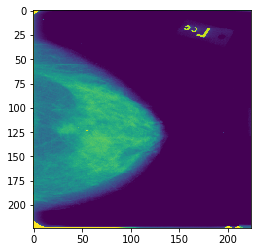

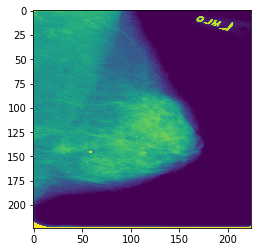

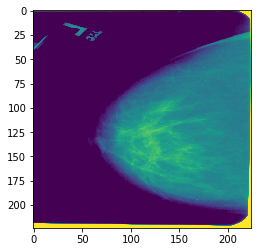

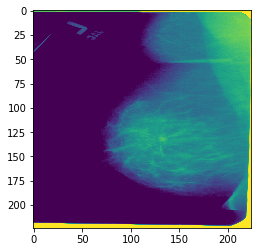

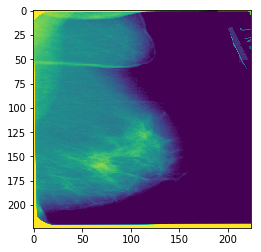

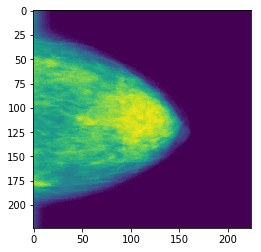

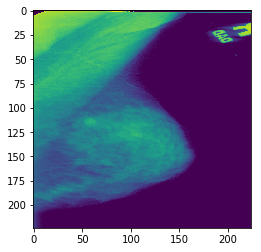

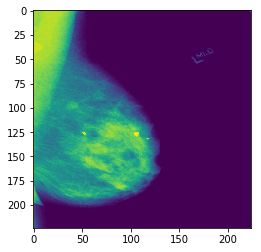

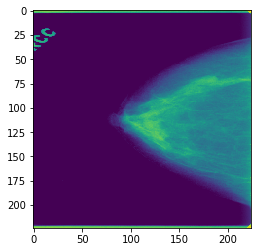

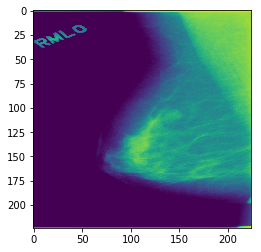

In [37]:
for imag in xTrain[:10]:
    plt.imshow(imag)
    plt.show()

## NumpyZ Files with training and test data

In [60]:
np.savez_compressed("data/mini_project_data.npz", xTrain=xTrain, xTest=xTest, yTrain=yTrain, yTest=yTest)

In [61]:
l = np.load("data/mini_project_data.npz")

In [62]:
print(np.shape(l['xTest']), np.shape(l['xTrain']))
print(np.shape(l['yTest']), np.shape(l['yTrain']))

(56, 224, 224) (341, 224, 224)
(56, 4) (341, 4)


## Training the ResNet

In [366]:
class BreastDataSequence(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return [np.array(batch_x), np.array(batch_y)]

In [369]:
data_sequence = BreastDataSequence(get_X(xTrain), yTrain, 19)
val_sequence = BreastDataSequence(get_X(xTest), yTest, 10)

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 4 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(data_sequence, epochs=3, validation_data=val_sequence)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',  metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(data_sequence, epochs=3, validation_data=val_sequence)

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/3
18/18 [==============================] - 78s 4s/step - loss: 9.4539 - acc: 0.3694 - val_loss: 7.8048 - val_acc: 0.3393
Epoch 2/3
18/18 [==============================] - 68s 4s/step - loss: 9.9234 - acc: 0.3843 - val_loss: 7.8048 - val_acc: 0.3393
Epoch 3/3
18/18 [==============================] - 65s 4s/step - loss: 9.9234 - acc: 0.3843 - val_loss: 7.8048 - val_acc: 0.3393
0 input_11
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_716
5 max_pooling2d_26
6 res2a_branch2a
7 bn2a_branch2a
8 activation_717
9 res2a_branch2b
10 bn2a_branch2b
11 activation_718
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_81
17 activation_719
18 res2b_branch2a
19 bn2b_branch2a
20 activation_720
21 res2b_branch2b
22 bn2b_branch2b
23 activation_721
24 res2b_branch2c
25 bn2b_branch2c
26 add_82
27 activation_722
28 res2c_branch2a
29 bn2c_branch2a
30 activation_723
31 res2c_branch2b
32 bn2c_branch2b
33 activation_724
34 res2c_branch2c
35 bn2c_branch2c
36 add_83
37 activation_725

## Evaluation (Precision and Recall)

In [374]:
y_pred = model.predict(get_X(xTest))

In [384]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(yTest, np.round(y_pred)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         8
          1       0.34      1.00      0.51        19
          2       0.00      0.00      0.00        24
          3       0.00      0.00      0.00         5

avg / total       0.12      0.34      0.17        56



/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
